# AlexNet (CIFAR-10)
This notebook demonstrates the AlexNet convolutional neural network for CIFAR-10 image classification. It includes data loading, preprocessing, model definition, training, evaluation, and visualization of predictions.

### Detailed step explanations

- Preprocessing (normalization & reshape): We convert images to `float32` and scale pixel values from [0,255] to [0,1]. This improves numerical stability and speeds up optimization. CIFAR-10 images are already in the correct shape (32x32x3), so no additional reshaping is needed beyond ensuring the channel axis is properly positioned.

- Model architecture (AlexNet): Convolutional layers with ReLU activations extract hierarchical features from images. Max pooling layers reduce spatial dimensions and provide translation invariance. Dropout layers are added to prevent overfitting by randomly deactivating neurons during training. Fully connected layers combine these features for classification. The final softmax layer outputs class probabilities for the 10 CIFAR-10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).

- `model.summary()`: Prints a table listing each layer's name, output shape, and number of parameters. Use it to validate layer shapes, confirm the final output dimension matches the number of classes, and to inspect the model's capacity (total trainable parameters).

- Compile step: Sets the optimizer (how weights are updated), the loss function (the objective to minimize), and metrics to report. For example, `optimizer='adam'` (adaptive optimizer), `loss='sparse_categorical_crossentropy'` (for integer labels), and `metrics=['accuracy']` to monitor classification accuracy.

- Training (`model.fit`): `epochs` controls how many passes over the dataset are made; `batch_size` controls how many samples are seen per gradient update (tradeoffs in noise and speed); `validation_split` reserves part of training data to evaluate generalization during training. The returned `History` object contains time-series metrics useful for diagnosing under/overfitting.

## Step 1 — Libraries and reproducibility
Import required libraries and set random seeds to ensure reproducible results.

In [1]:
# Import necessary libraries and set seeds for reproducibility
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Reproducibility: set a global seed (note: perfect determinism depends on the environment)
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Step 2 — Load the CIFAR-10 dataset
The CIFAR-10 dataset contains 60,000 color images of 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck) sized 32×32 pixels. It is provided as two tuples: `(x_train, y_train)` and `(x_test, y_test)`. The `x` arrays have shape `(num_samples, 32, 32, 3)` and the `y` arrays contain integer labels in `[0,9]`.

Running quick sanity checks (shapes, example values) ensures data was loaded correctly and helps catch issues such as unexpected color channels, incorrect dtypes, or corrupted files.

In [2]:
# Load CIFAR-10 dataset from Keras datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Display shapes: (num_samples, 32, 32, 3)
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)

x_train: (50000, 32, 32, 3)
y_train: (50000, 1)


## Step 3 — Preprocessing: normalization & reshape
Why normalize: Neural networks typically train faster and more stably when inputs are scaled to a small, consistent range. Dividing by 255 maps pixel values from [0,255] to [0,1], improving numerical stability and gradient behavior.

Why reshape: CIFAR-10 images are already in the correct shape (32x32x3), so no additional reshaping is needed beyond ensuring the channel axis is properly positioned. Also converting to `float32` reduces memory usage and ensures compatibility with TensorFlow operations.

In [3]:
# Normalize pixel values to [0, 1] and ensure float32 dtype
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print('x_train (after preprocess):', x_train.shape)
print('x_test (after preprocess):', x_test.shape)

x_train (after preprocess): (50000, 32, 32, 3)
x_test (after preprocess): (10000, 32, 32, 3)


In [4]:
print(y_train[:5])


[[6]
 [9]
 [9]
 [4]
 [1]]


## Step 4 — Build the AlexNet model
This block defines the neural network architecture. AlexNet structure includes multiple convolutional layers with ReLU activations, max pooling for downsampling, dropout for regularization, and fully connected layers for classification.

- Convolutional layers learn spatial filters that detect edges, textures, and higher-level patterns.
- Pooling layers reduce spatial resolution, lowering computational cost and providing a degree of translational invariance.
- Dropout randomly deactivates neurons during training to prevent overfitting.
- Flatten converts spatial feature maps to a vector consumed by fully connected layers, which learn nonlinear combinations for classification.
- The final softmax layer produces probabilities across the 10 CIFAR-10 classes.

In [5]:
model = models.Sequential([

    # -------- Conv Block 1 --------
    layers.Conv2D(
        filters=96,
        kernel_size=(3, 3),
        strides=(1, 1),
        activation='relu',
        input_shape=(32, 32, 3)
    ),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # -------- Conv Block 2 --------
    layers.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # -------- Conv Block 3 --------
    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # -------- Classifier --------
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(10, activation='softmax')
])


## Step 5 — Inspect model summary
`model.summary()` prints a table with the layer names, output shapes, and number of parameters per layer. Use it to verify the following:

- Layer order and output shapes match your design.
- The final output shape equals the number of classes (10 for CIFAR-10).
- Total number of parameters (trainable + non-trainable) fits memory and capacity expectations.

This information helps detect shape mismatches early and reason about model capacity and potential overfitting.

In [6]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 256)       221440    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 384)         1

## Step 6 — Compile the model
Compiling configures the training process. Key items:

- Optimizer (`optimizer='adam'`): algorithm that updates model weights using gradients; Adam adapts learning rates per parameter and often converges quickly.
- Loss (`loss='sparse_categorical_crossentropy'`): objective to minimize; the 'sparse_' variant expects integer class labels; use `categorical_crossentropy` if labels are one-hot.
- Metrics (`metrics=['accuracy']`): functions calculated and reported during training/evaluation; accuracy reports the fraction of correct predictions.

You can pass optimizer objects (e.g., `tf.keras.optimizers.Adam(learning_rate=1e-3)`) to customize behavior such as learning rate.

In [7]:
# Compile model with Adam optimizer and sparse categorical crossentropy loss (suitable for integer labels)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Step 7 — Train the model
Training iteratively updates model weights to minimize the loss on the training set.

- `epochs`: number of full passes over the training set.
- `batch_size`: number of samples processed before each gradient update (trade-off between speed and noise in updates).
- `validation_split`: fraction of training data reserved for monitoring validation metrics.

The `fit` method returns a `History` object with per-epoch metrics (loss, accuracy) for both training and validation.

In [8]:
# Training hyperparameters
EPOCHS = 10
BATCH_SIZE = 128

history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1)

Epoch 1/10
352/352 [==============================] - 242s 686ms/step - loss: 1.7610 - accuracy: 0.3311 - val_loss: 1.3473 - val_accuracy: 0.4996
Epoch 2/10
352/352 [==============================] - 330s 939ms/step - loss: 1.2185 - accuracy: 0.5576 - val_loss: 1.0745 - val_accuracy: 0.6168
Epoch 3/10
352/352 [==============================] - 268s 760ms/step - loss: 0.9992 - accuracy: 0.6472 - val_loss: 0.8858 - val_accuracy: 0.6906
Epoch 4/10
352/352 [==============================] - 325s 924ms/step - loss: 0.8569 - accuracy: 0.7010 - val_loss: 0.8928 - val_accuracy: 0.6862
Epoch 5/10
352/352 [==============================] - 418s 1s/step - loss: 0.7328 - accuracy: 0.7446 - val_loss: 0.8036 - val_accuracy: 0.7190
Epoch 6/10
352/352 [==============================] - 422s 1s/step - loss: 0.6473 - accuracy: 0.7755 - val_loss: 0.7906 - val_accuracy: 0.7328
Epoch 7/10
352/352 [==============================] - 354s 1s/step - loss: 0.5634 - accuracy: 0.8050 - val_loss: 0.7640 - val_accu

## Step 8 — Inspect training curves and evaluate on test set
After training, visualize training and validation loss/accuracy to check for convergence and generalization. Use these plots to decide whether to train longer, change regularization, or augment the data.

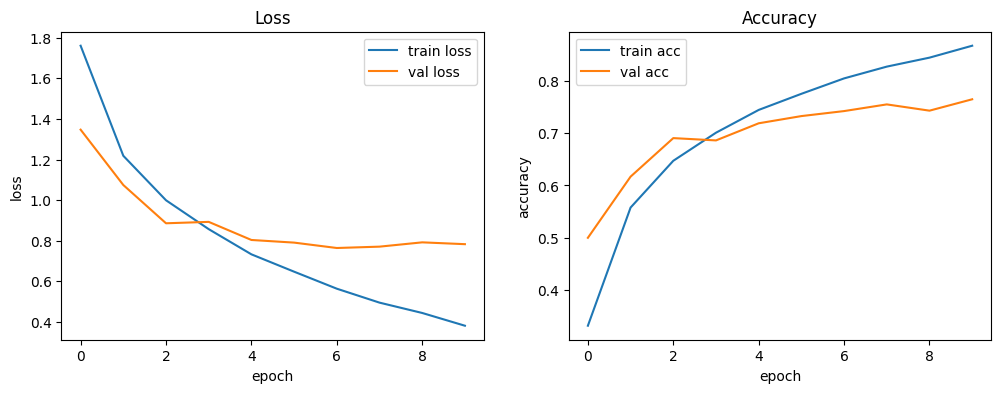

In [9]:
# Plot training history (loss and accuracy)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.title('Accuracy')
plt.show()

In [10]:
def analyze_model_limits(
    history,
    test_accuracy,
    bayes_accuracy_estimate=0.99,
    model_name="Model"
):
    """
    Compares training, validation, test accuracy against
    an estimated Bayesian upper bound.
    """

    # Final epoch metrics
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]

    print(f"\n📊 Performance Analysis for {model_name}")
    print("-" * 45)

    print(f"Training Accuracy     : {train_acc:.4f}")
    print(f"Validation Accuracy   : {val_acc:.4f}")
    print(f"Test Accuracy         : {test_accuracy:.4f}")
    print(f"Estimated Bayes Limit : {bayes_accuracy_estimate:.4f}")

    print("\n🔍 Gaps")
    print(f"Train → Val Gap  : {train_acc - val_acc:.4f}")
    print(f"Val → Test Gap   : {val_acc - test_accuracy:.4f}")
    print(f"Bayes → Test Gap : {bayes_accuracy_estimate - test_accuracy:.4f}")

    print("\n🧠 Diagnosis")

    if train_acc - val_acc > 0.05:
        print("• Likely OVERFITTING → regularization or more data needed")

    elif train_acc < 0.7:
        print("• Likely UNDERFITTING → model capacity too low")

    elif bayes_accuracy_estimate - test_accuracy < 0.02:
        print("• Near Bayesian limit → diminishing returns")

    else:
        print("• Still room for improvement")

    print("-" * 45)


In [11]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy:", test_accuracy)

analyze_model_limits(
    history=history,
    test_accuracy=test_accuracy,
    bayes_accuracy_estimate=0.99,  # CIFAR-10 proxy
    model_name="AlexNet (CIFAR-10)"
)

313/313 [==============================] - 34s 109ms/step - loss: 0.8507 - accuracy: 0.7440
Test accuracy: 0.7440000176429749

📊 Performance Analysis for AlexNet (CIFAR-10)
---------------------------------------------
Training Accuracy     : 0.8676
Validation Accuracy   : 0.7650
Test Accuracy         : 0.7440
Estimated Bayes Limit : 0.9900

🔍 Gaps
Train → Val Gap  : 0.1026
Val → Test Gap   : 0.0210
Bayes → Test Gap : 0.2460

🧠 Diagnosis
• Likely OVERFITTING → regularization or more data needed
---------------------------------------------


## Step 9 — Validate and visualise predictions

1/1 [==============================] - 0s 43ms/step


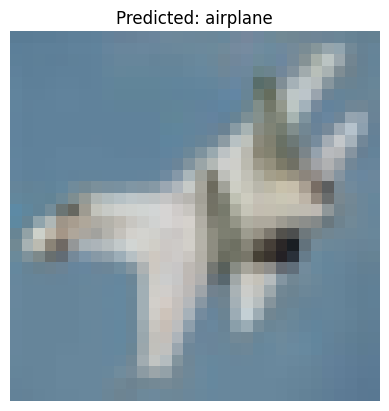

In [ ]:
# Example inference and visualization for a single test example
index = 1
prediction = model.predict(x_test[index:index+1])
predicted_label = np.argmax(prediction)

plt.imshow(x_test[index])
plt.title(f"Predicted: {class_names[predicted_label]}")
plt.axis('off')
plt.show()